In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from google.colab import data_table

In [2]:
#note - read with skip spaces (there are some space columns, these become NaN)
telco_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Telco-Customer-Churn.csv', skipinitialspace=True)
telco_data.shape

(5070, 21)

In [3]:
#telco_data.head()
data_table.DataTable(telco_data, include_index=False, num_rows_per_page=10)

Output hidden; open in https://colab.research.google.com to view.

In [4]:
telco_data.Churn.value_counts()

No     3738
Yes    1332
Name: Churn, dtype: int64

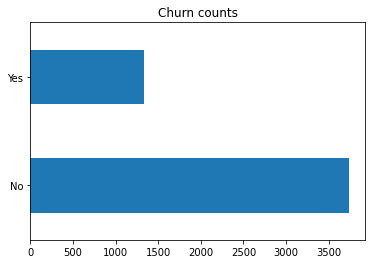

In [5]:
telco_data.Churn.value_counts().plot(kind='barh', title='Churn counts')
plt.show() 

# Data Pre-processing

In [6]:
#column types
print(telco_data.dtypes)
print(telco_data.dtypes.shape)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
(21,)


In [7]:
# there are 8 rows with no values for TotalCharges, copy over MonthlyCharge as TotalCharge
#telco_data[telco_data['TotalCharges'].isna()]
telco_data.TotalCharges.fillna(telco_data.MonthlyCharges, inplace=True)
#telco_data[telco_data['TotalCharges'].isna()]

In [8]:
# remove customer id
telco_data.drop(columns='customerID', inplace=True)

In [9]:
numerical_cols = telco_data.columns[(telco_data.dtypes=='int') | (telco_data.dtypes=='float')].tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [10]:
categorical_cols = telco_data.columns[telco_data.dtypes=='object'].tolist()
print(len(categorical_cols))
categorical_cols

16


['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [11]:
single_valued_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() == 1].index.tolist()
single_valued_colmmns

[]

In [12]:
binary_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() == 2].index.tolist()
binary_colmmns

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [13]:
multi_valued_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() > 2].index.tolist()
multi_valued_colmmns

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [14]:
# Transform binary_columns
telco_data.Churn = telco_data.Churn.replace({'Yes':1, 'No':0}) 
# For binary columns will set values as 0 and 1
for column in binary_colmmns :
  telco_data[column] = LabelEncoder().fit_transform(telco_data[column])

In [15]:
# get dummies for multi-value. Note: looked in excel, each column only have 3 to 5 values so should be ok
# Creating dummies for ALL multi-value columns and removing the original column
dummies_adjusted_data = pd.get_dummies(data = telco_data, columns=multi_valued_colmmns, drop_first=True)
dummies_adjusted_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,1,1,0,0,33,1,1,24.90,847.80,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0
5066,1,0,1,0,44,0,0,54.30,2390.45,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0
5067,0,0,1,1,30,1,0,66.30,1923.50,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5068,0,0,1,0,71,1,1,20.90,1493.20,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0


In [16]:
#Z-Score normalization - create normal distribution in each numerical column
numerical_columns = dummies_adjusted_data[numerical_cols]
scaled_numerical = numerical_columns.div(numerical_columns.mean(), axis=1)
scaled_numerical

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.000000,0.031027,0.460963,0.013162
1,0.000000,1.054912,0.879459,0.833132
2,0.000000,0.062054,0.831587,0.047686
3,0.000000,1.396207,0.653224,0.811636
4,0.000000,0.062054,1.091796,0.066867
...,...,...,...,...
5065,6.251541,1.023885,0.384522,0.373818
5066,0.000000,1.365180,0.838536,1.054014
5067,0.000000,0.930805,1.023848,0.848123
5068,0.000000,2.202904,0.322751,0.658392


In [17]:
#dropping original values merging scaled values for numerical columns
dummies_adjusted_data = dummies_adjusted_data.copy()# why is this copy needed?
data = dummies_adjusted_data.drop(columns = numerical_cols,axis = 1)
data = data.merge(scaled_numerical,left_index=True,right_index=True,how = "left")
data

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.031027,0.460963,0.013162
1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0.000000,1.054912,0.879459,0.833132
2,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.062054,0.831587,0.047686
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0.000000,1.396207,0.653224,0.811636
4,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.062054,1.091796,0.066867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,6.251541,1.023885,0.384522,0.373818
5066,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0.000000,1.365180,0.838536,1.054014
5067,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.000000,0.930805,1.023848,0.848123
5068,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0.000000,2.202904,0.322751,0.658392


# Multi-Collinearity

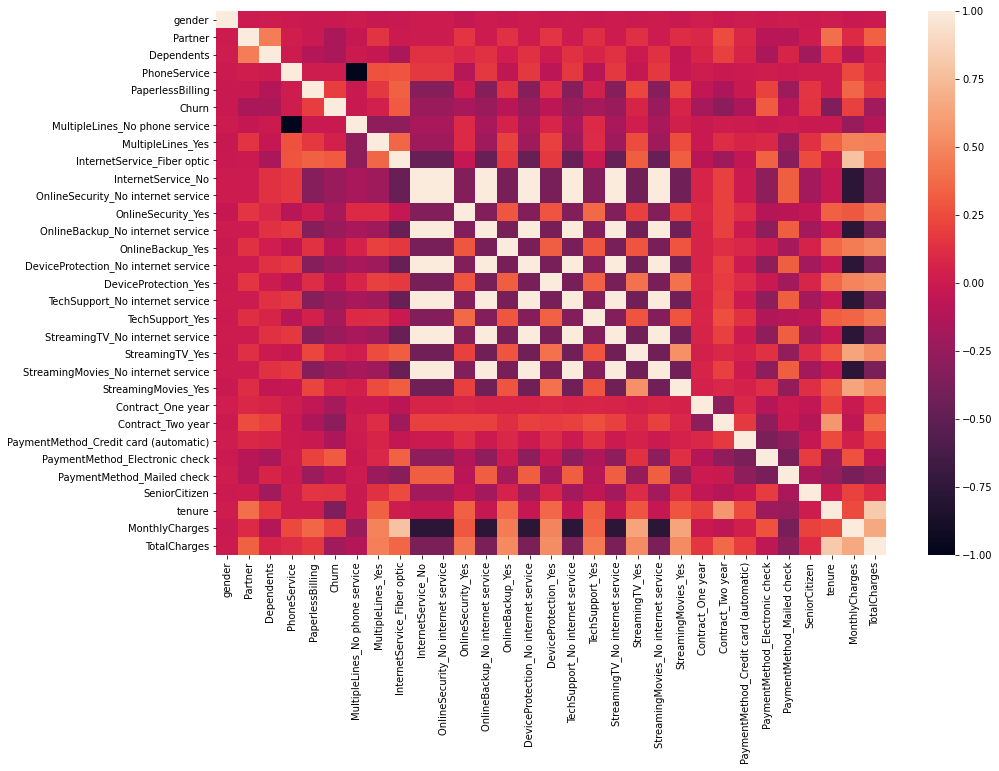

In [18]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

In [19]:
cols_to_melt = corr_matrix.columns
#print(cols_to_melt)
corr_matrix = corr_matrix.reset_index()
corr_matrix_melted = corr_matrix.melt( id_vars='index', value_vars=cols_to_melt)
corr_matrix_melted = corr_matrix_melted[corr_matrix_melted['index'] != corr_matrix_melted['variable']]
corrlations_above_threshold = corr_matrix_melted[corr_matrix_melted.value.abs() > .8]
columns_to_drop = corrlations_above_threshold['index'].to_list()
columns_to_drop

['MultipleLines_No phone service',
 'PhoneService',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No 

In [20]:
data.drop(columns=columns_to_drop, inplace=True)

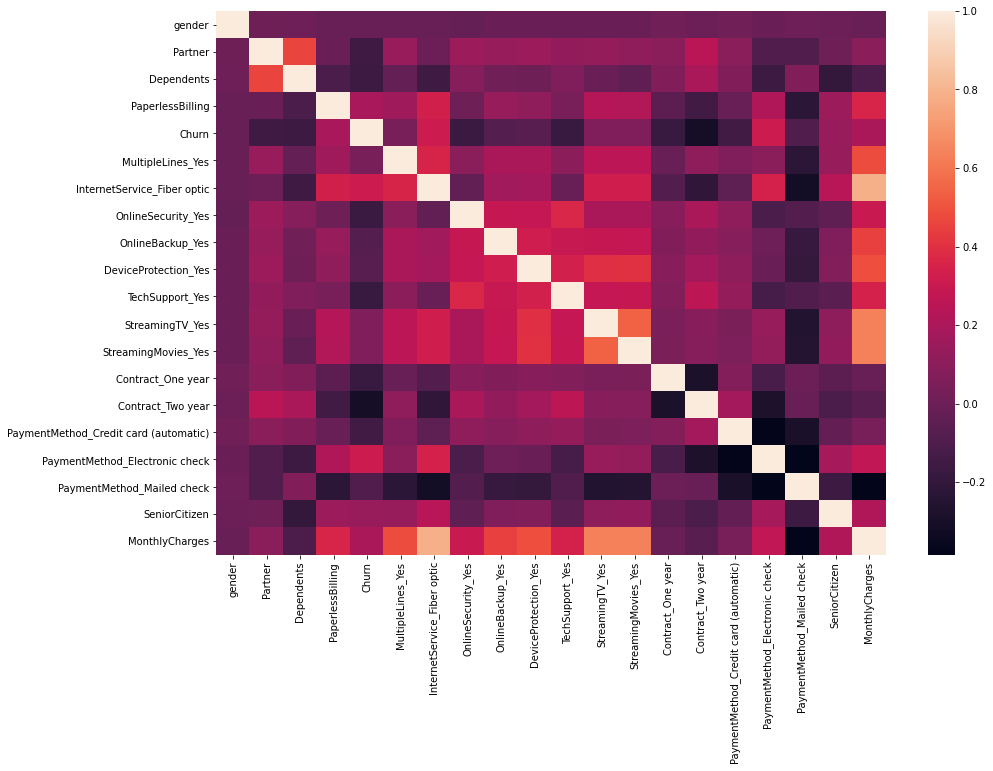

In [21]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

# Balance and Splitting data

In [22]:
data.Churn.value_counts()

0    3738
1    1332
Name: Churn, dtype: int64

In [23]:
positive_labels = data[data.Churn==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

1332

In [24]:
#randomly take same number of negative rows as number of positive rows
negative_labels = data[data.Churn==0].sample(num_positive_labels)
negative_labels.shape

(1332, 20)

In [25]:
balanced_data =  positive_labels.append(negative_labels)
balanced_data.Churn.value_counts()

1    1332
0    1332
Name: Churn, dtype: int64

In [26]:
y = balanced_data.pop('Churn') # Removing Churn field and storing it in variable y
X = balanced_data

In [27]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [28]:
#X_train.head()

# Fitting model

In [29]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities - this returns as a float (instead or 0 or 1)
predictions = clf.predict_proba(X_test)[:, 1]
#predictions

# Evaluating model

0.844180614674266


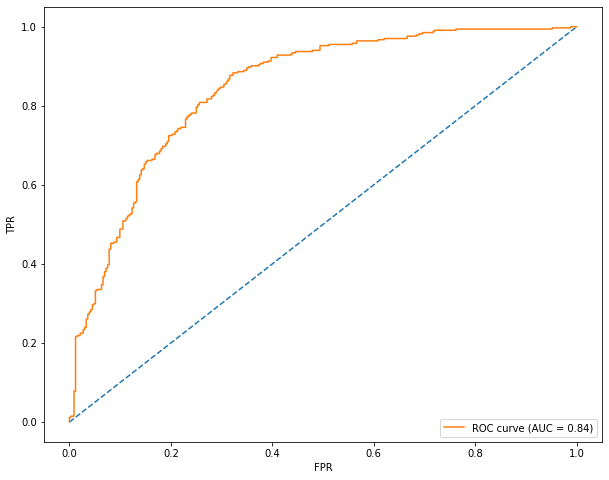

In [30]:
# calculate scores
auc = roc_auc_score(y_test, predictions)
print(auc)

# calculate roc curves
# fpr is false-postive rate, tpr is tru-positive rate
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

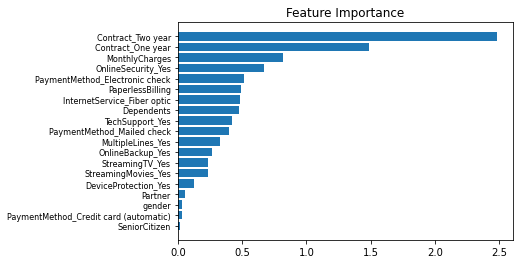

In [31]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.title('Feature Importance')
plt.show()

In [32]:
# Confusion matrix
#predict returns as 0 or 1 (vs proba)
y_pred = clf.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,241,91
1,61,273
